Data sources:
- [BPD FIO data](https://data.boston.gov/dataset/boston-police-department-fio) (2011 - 2019, I'm using data between 2015 and 2019)

(Some of the following codes were referenced from the data analysis done by [@jacoblurye](https://github.com/jacoblurye/bpd-fio-data/blob/master/process_bpd_fio_data.ipynb). Thanks to him, my data cleaning process was less painful.)

In [1]:
# import packages
import pandas as pd
import re
import datetime
import missingno as msno
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [2]:
# load in datasets from 2015 to 2019
''' there are two kinds of datasets - 
* field contacts data list each contact between BPD and one or more individuals
* field contacts name data list each individual involved in these contacts '''

ind_path191 = 'data/bpd/rms_fieldcontacts_name_for_public_2019.csv'
pol_path191 = 'data/bpd/rms_fieldcontacts_for_public_2019.csv'
ind_path192 = 'data/bpd/mark43_fieldcontacts_name_for_public_2019.csv'
pol_path192 = 'data/bpd/mark43_fieldcontacts_for_public_20192.csv'
ind_path18 = 'data/bpd/rms_fieldcontacts_name_for_public_2018_202003111443.csv'
pol_path18 = 'data/bpd/rms_fieldcontacts_2018.csv'
ind_path17 = 'data/bpd/rms_fieldcontacts_name_for_public_2017_202003111442.csv'
pol_path17 = 'data/bpd/rms_fieldcontacts_for_public_2017_202003111424.csv'
ind_path16 = 'data/bpd/fieldcontactnameforpublic2016.csv'
pol_path16 = 'data/bpd/fieldcontactforpublic2016.csv'
ind_path15 = 'data/bpd/fieldcontactnameforpublic2015.csv'
pol_path15 = 'data/bpd/fieldcontactforpublic2015.csv'
# pathB15 = 'data/bpd/boston-police-department-fio.csv'

ind_files = [ind_path191, ind_path192, ind_path18, ind_path17, ind_path16, ind_path15]
pol_files = [pol_path191, pol_path192, pol_path18, pol_path17, pol_path16, pol_path15]

def read_concat_csv(files):
    li = []

    for filename in files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    concated = pd.concat(li, axis=0, ignore_index=True)

    return concated


indvsl = read_concat_csv(ind_files)
plc = read_concat_csv(pol_files)

#### !!!IMPORTANT MSG from the BPD!!!

"While these two tables align on the field contact number (fc_num) column, it is not methodologically correct to join the two datasets for the purpose of generating aggregate statistics on columns from the FieldContact table. Doing so would lead to incorrect estimates stemming from contacts with multiple individuals. As noted in the Data Key (New RMS) file, several of the columns in the FieldContact table apply to the contact as a whole, but may not necessarily apply to each individual involved in the contact." These include:

- frisked
- searchperson
- summonsissued
- circumstances
- basis
- contact_reason


# 1.Data Cleaning

### Deal with the frisk/search columns in field contact (fc) dataset (a.k.a plc)

Something worth noting here is that the "frisked" and "searchperson" in the field contacts data, which was generated from the "New RMS" system, indicate at least one indivisual was frisked or searched in the incident. However, the fc data generated from MARK43 system (between SEPT 29 and DEC 31 2019) doesn't contain those two columns. The good news is that the fc name (a.k.a. indvsl) data from MARK43 documented the frisk/search value at an indivisual level, indicating whether the indivisual was frisked or searched during a field contact. 

In [3]:
# columns included in plc data
plc.columns

Index(['fc_num', 'contact_date', 'contact_officer', 'contact_officer_name',
       'supervisor', 'supervisor_name', 'street', 'city', 'state', 'zip',
       'frisked', 'searchperson', 'searchvehicle', 'summonsissued',
       'stop_duration', 'circumstance', 'basis', 'vehicle_year',
       'vehicle_state', 'vehicle_make', 'vehicle_model', 'vehicle_color',
       'vehicle_style', 'vehicle_type', 'contact_reason', 'key_situations',
       'narrative', 'weather', 'streetaddr'],
      dtype='object')

In [4]:
# number of rows and columns
plc.shape

(44105, 29)

In [5]:
# 35 records in the "contacts" dataset contain duplicate values in fc_num column, which should be an unique id. 
plc[plc.duplicated(subset=["fc_num"], keep=False)].shape

(35, 29)

In [6]:
# I kept the last record only. 
plc = plc.drop_duplicates(subset=["fc_num"], keep="last")

In [7]:
# lowercase all columns instead of fc_num
fcnum1 = plc["fc_num"]
plc = plc.applymap(lambda x: x.lower() if isinstance(x, str) else x)
plc["fc_num"] = fcnum1

fcnum2 = indvsl["fc_num"]
indvsl = indvsl.applymap(lambda x: x.lower() if isinstance(x, str) else x)
indvsl["fc_num"] = fcnum2


In [8]:
plc.frisked.unique()3

array([nan, 'y'], dtype=object)

In [8]:
# combine "frisked", "searchperson", "searchvehicle" columns into one, "frisked_or_searched_involved"
# remember: data generated from mark43 system will have a nan value because it doesn't contain this column
combine_method = (
        lambda row: "y"
        if row.frisked == "y" or row.searchperson == "y" or row.searchvehicle == "y"
        else "n"
    )

In [9]:
combined_plc = plc[["frisked", "searchperson", "searchvehicle"]].apply(
        combine_method, axis=1)

In [10]:
plc["person_involved_in_frisked_or_searched"] = combined_plc
plc = plc.drop(columns=["frisked", "searchperson", "searchvehicle"]).reset_index(drop=True)

### Deal with the frisk/search columns in fc name dataset (a.k.a. indvsl)

In [11]:
indvsl.columns

Index(['recnum', 'fc_num', 'contact_date', 'sex', 'race', 'age', 'build',
       'hair_style', 'complexion', 'ethnicity', 'otherclothing', 'skin_tone',
       'deceased', 'license_state', 'license_type', 'frisk/search'],
      dtype='object')

In [12]:
# To disambuate the frisk/search column from person_involved_in_frisked_or_searched in plc dataset,
# I rename it "frisk/search"
indvsl = indvsl.rename(columns={"frisk/search": "person_frisked_or_searched"})

In [13]:
# There will be lots of NaN values since only datasets generated from mark43 system have the "frisk/search" column
indvsl.person_frisked_or_searched.value_counts(dropna=False)

NaN    67742
0.0     1755
1.0     1040
Name: person_frisked_or_searched, dtype: int64

In [14]:
indvsl.person_frisked_or_searched = indvsl.person_frisked_or_searched.apply(lambda x: str(x))

In [15]:
# convert the value from 0 and 1 to n and y
indvsl.person_frisked_or_searched = indvsl.person_frisked_or_searched.replace({"0.0":"n", "1.0":"y"})

### Infer whether a filed contact involved a search/frisk conduct from indvsl dataset

In [16]:
''' 
Although the fc data in mark43 system doesn't provide frisked/searched info,
we can infer whether a field contact involved frisked/searched based on
the fc name data - whether the person invovled in the field contact were frisked or searched.
'''
plc_with_no_fs = plc.person_involved_in_frisked_or_searched.isnull()
indvsl_involved_fs = indvsl.groupby("fc_num").apply(
    lambda x: "y"
    if (x.person_frisked_or_searched == "y").any()
    else "n"
    if (x.person_frisked_or_searched == "n").all()
    else "n"
    )

In [17]:
plc.loc[plc_with_no_fs, "person_involved_in_frisked_or_searched"] = plc[
    plc_with_no_fs
].apply(lambda x: indvsl_involved_fs.loc[x.fc_num], axis=1)

### Datetime object

In [18]:
plc = plc.reset_index(drop=True)
indvsl = indvsl.reset_index(drop=True)

In [19]:
# one weird record should be dropped: 217-04-17 12:30:00
weird_date = "0217-04-17 12:30:00.0000000"
plc = plc[plc.contact_date != weird_date]
indvsl = indvsl[indvsl.contact_date != weird_date]

In [20]:
plc.contact_date = pd.to_datetime(plc.contact_date)
indvsl.contact_date = pd.to_datetime(indvsl.contact_date)

In [21]:
# delete data records before 2015
wrong_year = plc.contact_date.dt.year.astype(int) < 2015 #Again, create a true/false series
plc.loc[wrong_year, "contact_date"] = plc.contact_date[wrong_year] + pd.offsets.DateOffset(year=2015)
wrong_year = indvsl.contact_date.dt.year.astype(int) < 2015 #Again, create a true/false series
indvsl.loc[wrong_year, "contact_date"] = indvsl.contact_date[wrong_year] + pd.offsets.DateOffset(year=2015)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:692: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


### Clean zip

In [22]:
empty_street = plc.street.isnull()
plc.loc[empty_street, "street"] = plc.streetaddr[empty_street]
plc.street = plc.street.apply(lambda s: str(s).replace("&", "/"))

plc = plc.drop(columns=["streetaddr"])

plc.zip = plc.zip.apply(lambda zip: str(str(zip).split("-")[0]).split(".")[0])
plc.zip = plc.zip.apply(lambda zip: zip if len(zip) == 5 else "0"+zip)

### Clean vehicle info

In [23]:
plc.vehicle_type.unique()

array([nan, 'sedan', 'other', 'compact', 'suv or utility van',
       'station wagon', 'school bus', 'truck', 'bus/passenger van',
       'motorcycle or scooter', 'convertible',
       'passenger car/ automobile', 'cargo van',
       'suv (sport utility vehicle)', 'passenger van', 'pickup truck',
       'scooter', 'other vehicle', 'motorhome', 'construction vehicle'],
      dtype=object)

In [24]:
plc.vehicle_type = plc.vehicle_type.replace({
    "scooter": 'motorcycle or scooter',
    'suv (sport utility vehicle)': 'suv or utility van',
    'cargo van': 'suv or utility van',
    'passenger van': 'bus or passenger van',
    'bus/passenger van': 'bus or passenger van',
    'passenger car/ automobile':'passenger car'
    
})
                                        

In [25]:
plc.vehicle_color.unique()

array([nan, 'black ', 'gray', 'red', 'green ', 'blue', 'lt. blue',
       'white', 'silver', 'brown', 'tan ', 'orange', 'yellow', 'maroon ',
       'lt. green ', 'purple', 'gold', 'cream ', 'bla', 'black', 'green',
       'maroon', 'gra', 'tan', 'gre', 'light green', 'dark blue',
       'dark green', 'pink '], dtype=object)

In [26]:
plc.vehicle_color = plc.vehicle_color.str.rstrip().replace({
    "lt. blue": "light blue",
    "lt. green": "light green",
    "bla": "black",
    "gra": "gray",
    "gre": "grean"
})
            

In [27]:
plc.vehicle_year.value_counts(dropna=False)

NaN       28981
2015.0     1052
2004.0      983
2005.0      959
2008.0      943
          ...  
1981.0        1
1195.0        1
115.0         1
1971.0        1
1977.0        1
Name: vehicle_year, Length: 69, dtype: int64

In [28]:
def fix_year(col):
    if np.isnan(col):
        return col
    if col >= 1900:
        return col
    if (col > 99):
        return np.nan
    if col < 10:
        return f"200{col}"
    if col < 21:
        return f"20{col}"
    else:
        return f"19{col}"        

In [29]:
plc.vehicle_year = plc.vehicle_year.apply(fix_year)

### Combine contact reasons in new RMS and narrative in mark43

In [30]:
missing_contact_reason = plc.contact_reason.isnull()
plc.loc[missing_contact_reason, "contact_reason"] = plc[missing_contact_reason]["narrative"]
plc = plc.drop(columns=["narrative"]).reset_index(drop=True)

### Clean up city columns

In [31]:
plc.city.unique()

array(['bstn', 'boston', nan, 'roslindlae', 'roxbury', 'mattapan',
       'dorchester', 'btsn', 'allston', 'jamaica plain', 'east boston',
       'charlestown', 'south boston', 'revere', 'brighton', 'bsnt',
       'bstna', 'bston', 'palm springs', 'brookline', 'hyde park',
       'jamaiaca plain', 'roslindale', 'west roxbury', 'everett',
       'worcester', 's. boston', 'sommerville', 'milton', 'pembroke',
       'holbrook', 'jamaicia plain', 's.boston', 'dor.', 'e boston',
       'e.boston', 's boston', 'bostob', 'brockton', 'weymouth',
       'dorchest', 'sbos', 'jp', 'chelsea', 'mission hill', 'charlestwon',
       'jamacia plain', 'rox', 'robury', 'so boston', 'so. boston',
       'dorcchester', 'chaarlestown', 'east bos', 'chalrestown',
       'east bostn', 'dor', 'unkown', 'mt', 'andover', 'quincy',
       'dorchster', 'south end', 'dedham', 'bst', 's bstn', 'dorchesterr',
       'canton', 'south  boston', 'jamaiica plain', 'roxbury ma',
       'e. boston', 'jamaica', '307', 'ddo

In [32]:
BOSTON = "boston"
SOUTHIE = "south boston"
DORCHESTER = "dorchester"
CHARLESTOWN = "charlestown"
JP = "jamaica plain"
EASTIE = "east boston"
MATTAPAN = "mattapan"
ROXBURY = "roxbury"
HYDEPARK = "hyde park"

plc.city = plc.city.replace(
        {
            "bstn": BOSTON,
            "so.boston": SOUTHIE,
            "dorcchester": DORCHESTER,
            "chaarlestown": CHARLESTOWN,
            "jp": JP,
            "east bos": EASTIE,
            "chalrestown": CHARLESTOWN,
            "east bostn": EASTIE,
            "dor": DORCHESTER,
            "mt": MATTAPAN,
            "s boston": SOUTHIE,
            "dorchster": DORCHESTER,
            "bst": BOSTON,
            "s bstn": SOUTHIE,
            "dorchesterr": DORCHESTER,
            "jamaiica plain": JP,
            "roxbury ma": ROXBURY,
            "so boston": SOUTHIE,
            "e. boston": EASTIE,
            "jamaica": JP,
            "ddorchester": DORCHESTER,
            "mattpan": MATTAPAN,
            "jamaicia": JP,
            "s. boston": SOUTHIE,
            "hp": HYDEPARK,
            "dorchest": DORCHESTER,
            "sbos": SOUTHIE,
            "rox": ROXBURY,
            "charlestwon": CHARLESTOWN,
            "jamacia plain": JP,
            "robury": ROXBURY,
            "btsn": BOSTON,
            "sommerville": "somerville",
            "jamaicia plain": JP,
            "s.boston": SOUTHIE,
            "dor.": DORCHESTER,
            "e boston": EASTIE,
            "e.boston": EASTIE,
            "bostob": BOSTON,
            "roslindlae": "ROSLINDALE",
            "bsnt": BOSTON,
            "bstna": BOSTON,
            "bston": BOSTON,
            "jamaiaca plain": JP,
            "so. boston": SOUTHIE,
            "unkown": "unknown",
        })
                           

### Clean up age

In [33]:
indvsl.age.describe()

count    68899.000000
mean        28.678109
std         12.523940
min         -4.000000
25%         21.000000
50%         26.000000
75%         33.000000
max        952.000000
Name: age, dtype: float64

In [34]:
indvsl.age = indvsl.age.apply(
    lambda x:
        x if (x > 0) & (x < 100)
        else np.nan
    )

### Merge skin tone column in mark34 with complexion column in new rms

In [35]:
missing_complexion = indvsl.complexion.isnull()
indvsl.loc[missing_complexion, "complexion"] = indvsl[missing_complexion]["skin_tone"]
indvsl = indvsl.drop(columns="skin_tone").reset_index(drop=True)

### Reconcile race

In [36]:
indvsl.race = indvsl.race.replace(
        {"american indian or alaskan native": "native american / alaskan native"}
    )

### Correct state name

In [37]:
plc.state = plc.state.replace({"MX": "MA"})

### Reconcile stop duration 

In [38]:
plc.stop_duration.unique()

array(['five to ten minutes', 'ten to fifteen minutes',
       'less than five minutes', 'thirty to forty-five minutes',
       'fifteen to twenty minutes', nan, 'twenty-five to thirty minutes',
       'forty-five to sixty minutes', 'twenty to twenty-five minutes',
       'longer than two hours', 'one to two hours', 60.0, 0.0, 3.0, 14.0,
       740.0, 5.0, 41.0, 10.0, 44.0, 15.0, 39.0, 31.0, 29.0, 21.0, 20.0,
       28.0, 8.0, 40.0, 6.0, 25.0, 17.0, 46.0, 149.0, 23.0, 120.0, 7.0,
       13.0, 18.0, 82.0, 2.0, 26.0, 9.0, 195.0, 32.0, 1.0, 144.0, 16.0,
       30.0, 67745.0, 11.0, 48.0, 49.0, 55.0, 52.0, 19.0, 820.0, 107.0,
       105.0, 4.0, 24.0, 1505.0, 200.0, 990.0, 45.0, 80.0, 1440.0, 43.0,
       1035.0, 38.0, 58.0, 129.0, 11530.0, 47.0, 67578.0, 33.0, 68.0,
       65.0, 131.0, 90.0, 595.0, 674.0, 285.0], dtype=object)

In [39]:
def bucket_stop_duration(d):
        try:
            d = int(d)
        except:
            return d

        if d > 1000:
            return np.nan
        if d < 5:
            return "less than five minutes"
        if d < 10:
            return "five to ten minutes"
        if d < 15:
            return "ten to fifteen minutes"
        if d < 20:
            return "fifteen to twenty minutes"
        if d < 25:
            return "twenty to twenty-five minutes"
        if d < 30:
            return "twenty-five to thirty minutes"
        if d < 45:
            return "thirty to forty-five minutes"
        if d < 60:
            return "forty-five to sixty minutes"
        if d < 120:
            return "one to two hours"
        return "longer than two hours"

plc.stop_duration = plc.stop_duration.apply(bucket_stop_duration)

### Add a year column for future use

In [40]:
# add year column
plc["year"] = plc.contact_date.dt.year.astype(str)
indvsl["year"] = indvsl.contact_date.dt.year.astype(str)

### Reconcile NaN values

In [41]:
replacements = {"": np.nan, "null": np.nan, "none": np.nan}
plc = plc.replace(replacements)
indvsl = indvsl.replace(replacements)

### Calculate number of indivisals involved in a field contact

In [42]:
num_of_indvsl = indvsl.groupby(["fc_num"]).count()["contact_date"]
plc["num_of_stopped_people"] = plc["fc_num"].apply(lambda x: num_of_indvsl[x])

### Missing Values

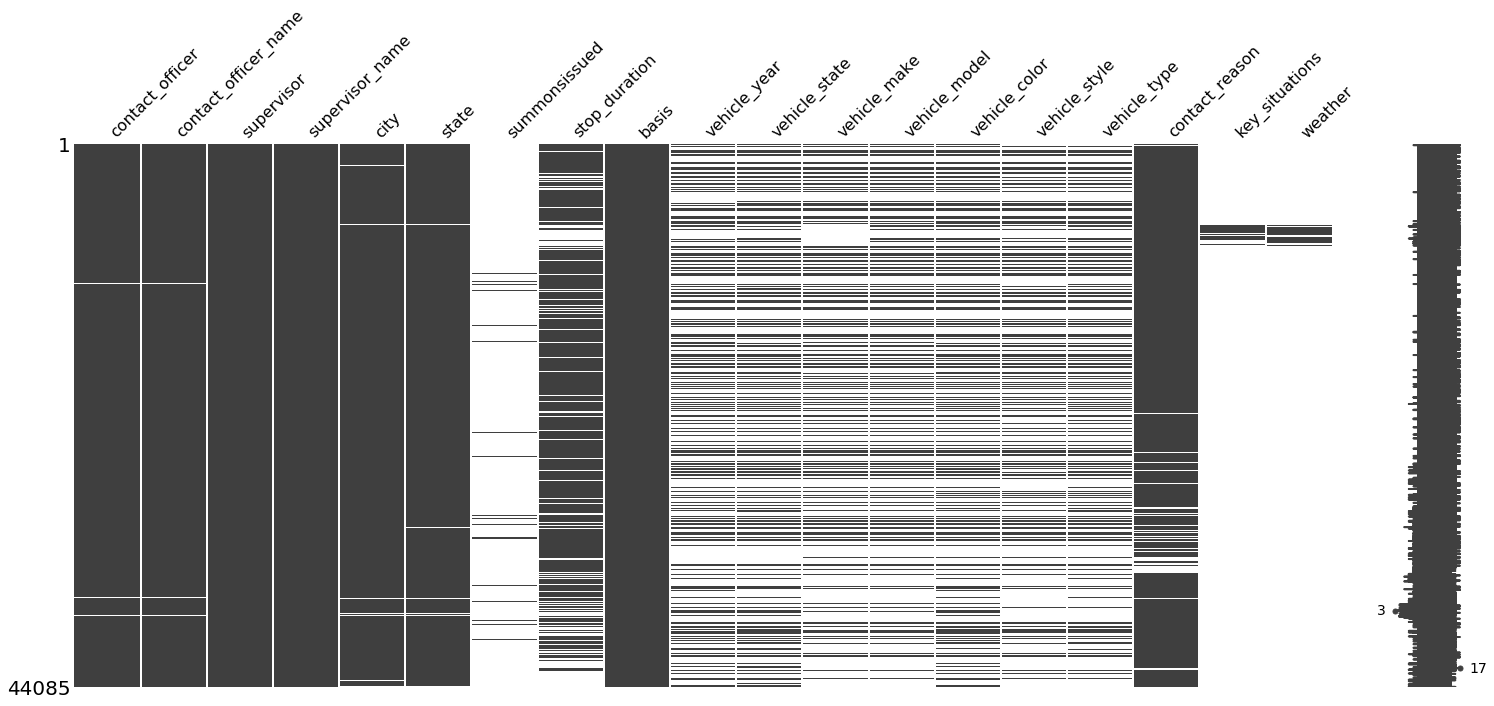

In [43]:
missingdata_plc = plc.columns[plc.isnull().any()].tolist()
msno.matrix(plc[missingdata_plc])

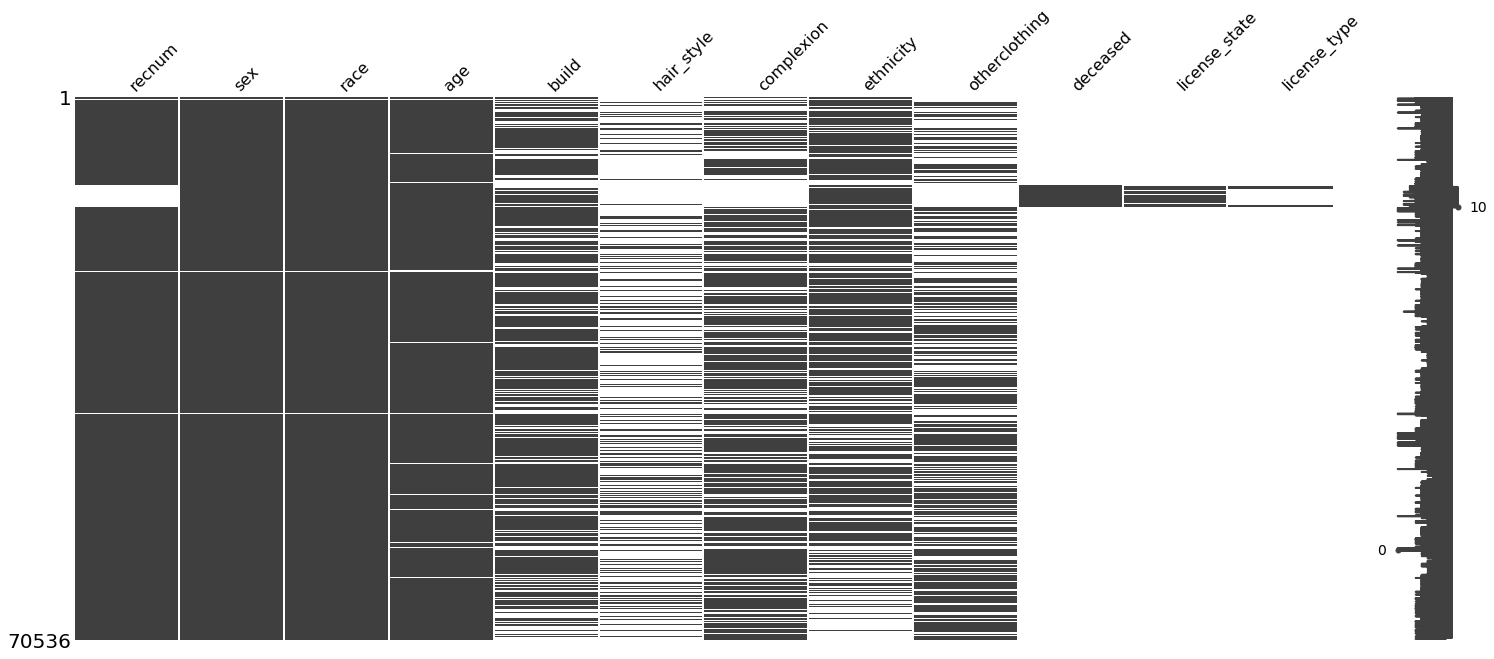

In [44]:
missingdata_indvsl = indvsl.columns[indvsl.isnull().any()].tolist()
msno.matrix(indvsl[missingdata_indvsl])

Based on the above missing value analysis, we can see that some columns are irrelevant or not useful to our analysis as there are too many missing values. I decided to remove the following columns:
- deceased
- license state
- license type
- key situations
- weather

In [45]:
indvsl.drop(['deceased', 'license_state', 'license_type'], axis='columns', inplace=True)
plc.drop(['key_situations', 'weather'], axis='columns', inplace=True)

In [52]:
plc.columns

Index(['fc_num', 'contact_date', 'contact_officer', 'contact_officer_name',
       'supervisor', 'supervisor_name', 'street', 'city', 'state', 'zip',
       'summonsissued', 'stop_duration', 'circumstance', 'basis',
       'vehicle_year', 'vehicle_state', 'vehicle_make', 'vehicle_model',
       'vehicle_color', 'vehicle_style', 'vehicle_type', 'contact_reason',
       'person_involved_in_frisked_or_searched', 'year',
       'num_of_stopped_people'],
      dtype='object')

### FINALLY, save the files

In [61]:
indvsl_merged = indvsl.merge(plc[["fc_num", "circumstance", "person_involved_in_frisked_or_searched", "zip", "street"]], left_on = 'fc_num', right_on = 'fc_num')

In [62]:
indvsl_merged.columns

Index(['recnum', 'fc_num', 'contact_date', 'sex', 'race', 'age', 'build',
       'hair_style', 'complexion', 'ethnicity', 'otherclothing',
       'person_frisked_or_searched', 'year', 'circumstance',
       'person_involved_in_frisked_or_searched', 'zip', 'street'],
      dtype='object')

In [63]:
plc.to_csv("cleaned_fc_data_2015_2019.csv")
indvsl_merged.to_csv("cleaned_fc_name_data_2015_2019.csv")